## 10-fold CV with 3-layer CNN max pooling on SR images - Reggresion

### Import and env settings

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import os

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

### Variables/parameters used in this notebook

In [4]:
ckpt_path = "./ckpt/reg_lr005/"
os.makedirs(ckpt_path, exist_ok=True)

SR_img_path = '../../data/SR_img/'

lr = 0.005
epochs = 120

### Prepare data

In [5]:
df = pd.read_csv('../../data/images/label_raw_price.csv')
df.head()

labels = df['SalePrice'].to_numpy()
labels.shape


(2911,)

In [6]:
images_arr = []

for i in range(1, len(labels)+1):
# for i in range(1, 10):
    img = plt.imread(os.path.join(SR_img_path, 'SR_img_{}.png'.format(i)))
    images_arr.append(img)

images_arr = np.array(images_arr, dtype='float32')
images_arr.shape
    


(2911, 72, 72, 3)

#### train test splitting
- hold out 15% for testing
- use 85% to train model with K-fold CV

In [7]:
ttl_samples = images_arr.shape[0] 
test_ratio = 0.15
test_samples = int(test_ratio * images_arr.shape[0])

train_examples = images_arr[:-1*test_samples]
test_examples = images_arr[-1*test_samples:]
train_labels = labels[:-1*test_samples]
test_labels = labels[-1*test_samples:]


In [8]:
print('train: ', train_examples.shape)
print('test: ', test_examples.shape)
print('train label: ', train_labels.shape)
print('test label: ', test_labels.shape)

train:  (2475, 72, 72, 3)
test:  (436, 72, 72, 3)
train label:  (2475,)
test label:  (436,)


### Prepare model

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def create_reg_model(lr=0.005):

	# Working
	with tf.device('/cpu:0'):
		data_augmentation = tf.keras.Sequential([ 
			tf.keras.layers.RandomFlip("horizontal", input_shape=(72, 72, 3)),
	  		tf.keras.layers.RandomRotation(0.1),
		    tf.keras.layers.RandomZoom(0.1)
			])


	model = tf.keras.Sequential([
		# data_augmentation,
	  	# tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(72, 72,3)),
		tf.keras.layers.MaxPooling2D((2, 2)),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.MaxPooling2D((2,2)),
		tf.keras.layers.Dropout(0.1),
	  	tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(64, activation='relu'),
		tf.keras.layers.Dense(32, activation='relu'),
		tf.keras.layers.Dense(1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
	])

	# opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
	opt = tf.keras.optimizers.Adam(lr=lr)
	model.compile(optimizer=opt, loss=rmse, metrics=[rmse])

	return model


Num GPUs Available:  1


In [13]:
model = create_reg_model()
# model.summary()

In [14]:
history = model.fit(train_examples, train_labels, epochs=epochs, validation_data=(test_examples, test_labels))

Epoch 1/120


2022-04-30 22:04:27.121476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 82880.0938 - rmse: 82423.9219

2022-04-30 22:04:29.890986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 3s 25ms/step - loss: 82880.0938 - rmse: 82423.9219 - val_loss: 39427.4414 - val_rmse: 39219.7070
Epoch 2/120
78/78 [==============================] - 1s 12ms/step - loss: 42884.4258 - rmse: 42924.2578 - val_loss: 32693.8145 - val_rmse: 32545.2969
Epoch 3/120
78/78 [==============================] - 1s 12ms/step - loss: 41098.6211 - rmse: 41206.6055 - val_loss: 30623.4688 - val_rmse: 30414.0098
Epoch 4/120
78/78 [==============================] - 1s 12ms/step - loss: 38042.6406 - rmse: 38076.0078 - val_loss: 25980.3223 - val_rmse: 25667.4258
Epoch 5/120
78/78 [==============================] - 1s 12ms/step - loss: 34230.0547 - rmse: 34231.5195 - val_loss: 24325.1660 - val_rmse: 24074.0488
Epoch 6/120
78/78 [==============================] - 1s 12ms/step - loss: 32218.0859 - rmse: 32103.6445 - val_loss: 31000.2695 - val_rmse: 30665.5352
Epoch 7/120
78/78 [==============================] - 1s 12ms/step - loss: 29934.8301 - rmse: 29894.6758 - val_lo

2022-04-30 22:06:27.211655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


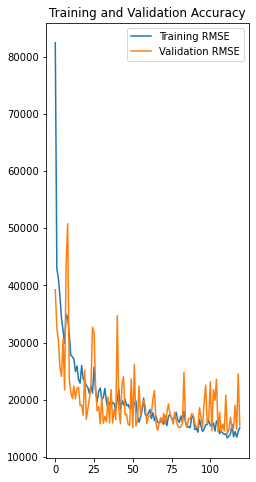

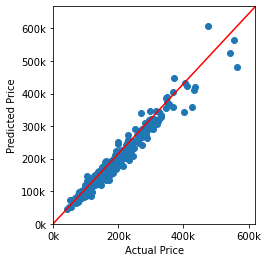

In [15]:
train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')


'''How far are predictions from real values?'''
from matplotlib.ticker import FuncFormatter

def format_tick_labels(x, pos):
    return '{:.0f}k'.format(x/1000)

predictions = model.predict(test_examples)

xlims = [0, max(test_labels)*1.1]
ylims = [0, max(predictions)*1.1]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(test_labels, predictions)
ax.xaxis.set_major_formatter(FuncFormatter(format_tick_labels))
ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')

ax.plot(xlims, ylims, 'r-')

### K-fold CV Training

In [16]:
from sklearn.model_selection import KFold

# modify to save ckpt for each test
ckpt = os.path.join(ckpt_path, "val_rmse_{val_rmse:.0f}.hdf5")

# training params
epochs = epochs
lr = lr

# the k for k fold CV
n_split = 10

# for recording best performance
min_loss = np.inf
best_history = None

'''
k-fold cross validation
Save the best model using validation accuracy as metric
Print the global best performace when finished
'''
for train_index, test_index in KFold(n_split).split(train_examples):

    x_train, x_vad = train_examples[train_index], train_examples[test_index]
    y_train, y_vad = train_labels[train_index], train_labels[test_index]

    model=create_reg_model(lr)
  
    # callbacks
    checkpoint_filepath = ckpt
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='auto',
        save_best_only=True,
        verbose=1
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        verbose=1,
        mode='auto',
    )

    # Model weights are saved at the end of every epoch, if it's the best seen so far.
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_vad, y_vad),
                        callbacks=[model_checkpoint_callback, early_stopping_callback])

    val_loss = max(history.history['val_loss'])
    
    if val_loss < min_loss:
        min_loss = val_loss
        best_history = history
        # print('Best acc so far. Saving params...\n')

print('Finish {}-fold cross validation'.format(n_split))
print('Best performing model has {} validation loss (RMSE)'.format(min_loss))



Epoch 1/120


2022-04-30 22:07:47.505405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 89944.2812 - rmse: 89624.1797
Epoch 1: val_loss improved from inf to 43987.60547, saving model to ./ckpt/5_class_lr005/val_rmse_44031.hdf5
70/70 [==============================] - 2s 19ms/step - loss: 89944.2812 - rmse: 89624.1797 - val_loss: 43987.6055 - val_rmse: 44030.8906
Epoch 2/120


2022-04-30 22:07:48.885436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/70 [============================>.] - ETA: 0s - loss: 46371.7344 - rmse: 46371.7344
Epoch 2: val_loss improved from 43987.60547 to 43963.42578, saving model to ./ckpt/5_class_lr005/val_rmse_44035.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 46539.8008 - rmse: 46653.1523 - val_loss: 43963.4258 - val_rmse: 44035.3867
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 40063.8711 - rmse: 40063.8711
Epoch 3: val_loss improved from 43963.42578 to 40522.51172, saving model to ./ckpt/5_class_lr005/val_rmse_40540.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 40102.8359 - rmse: 40223.0039 - val_loss: 40522.5117 - val_rmse: 40540.2891
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 37527.4141 - rmse: 37527.4141
Epoch 4: val_loss improved from 40522.51172 to 33671.87500, saving model to ./ckpt/5_class_lr005/val_rmse_33624.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 37071.9258 - rmse: 36973.5

2022-04-30 22:09:32.644967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 89149.6328 - rmse: 88864.7578
Epoch 1: val_loss improved from inf to 46789.15234, saving model to ./ckpt/5_class_lr005/val_rmse_47113.hdf5
70/70 [==============================] - 2s 15ms/step - loss: 89149.6328 - rmse: 88864.7578 - val_loss: 46789.1523 - val_rmse: 47113.0938
Epoch 2/120
 6/70 [=>............................] - ETA: 0s - loss: 47093.0234 - rmse: 47093.0234

2022-04-30 22:09:33.783676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/70 [============================>.] - ETA: 0s - loss: 43444.5820 - rmse: 43444.5820
Epoch 2: val_loss improved from 46789.15234 to 42837.86328, saving model to ./ckpt/5_class_lr005/val_rmse_43061.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 43392.7656 - rmse: 43357.8164 - val_loss: 42837.8633 - val_rmse: 43060.8867
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 39379.3008 - rmse: 39379.3008
Epoch 3: val_loss improved from 42837.86328 to 39060.05078, saving model to ./ckpt/5_class_lr005/val_rmse_39254.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 39312.0938 - rmse: 39266.7656 - val_loss: 39060.0508 - val_rmse: 39253.9922
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 35430.6836 - rmse: 35430.6836
Epoch 4: val_loss did not improve from 39060.05078
70/70 [==============================] - 1s 14ms/step - loss: 35480.5078 - rmse: 35478.2500 - val_loss: 41593.6133 - val_rmse: 41735.6641
Epoch 5/120
70/7

2022-04-30 22:10:37.450467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 82702.7812 - rmse: 82582.6641
Epoch 1: val_loss improved from inf to 51466.11719, saving model to ./ckpt/5_class_lr005/val_rmse_51142.hdf5
70/70 [==============================] - 2s 16ms/step - loss: 82702.7812 - rmse: 82582.6641 - val_loss: 51466.1172 - val_rmse: 51141.7227
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 40476.0469 - rmse: 40476.0469

2022-04-30 22:10:38.566858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 45969.0625 - rmse: 45969.0625
Epoch 2: val_loss improved from 51466.11719 to 47407.02734, saving model to ./ckpt/5_class_lr005/val_rmse_47053.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 45290.4531 - rmse: 45197.3203 - val_loss: 47407.0273 - val_rmse: 47053.2148
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 38037.9688 - rmse: 37968.3008
Epoch 3: val_loss improved from 47407.02734 to 43408.03906, saving model to ./ckpt/5_class_lr005/val_rmse_43193.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 38037.9688 - rmse: 37968.3008 - val_loss: 43408.0391 - val_rmse: 43193.3125
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 36893.5000 - rmse: 36893.5000
Epoch 4: val_loss improved from 43408.03906 to 40963.35547, saving model to ./ckpt/5_class_lr005/val_rmse_40826.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 36690.7656 - rmse: 36732.4

2022-04-30 22:11:48.197104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 84717.0312 - rmse: 84379.2656
Epoch 1: val_loss improved from inf to 46922.94922, saving model to ./ckpt/5_class_lr005/val_rmse_46887.hdf5
70/70 [==============================] - 2s 16ms/step - loss: 84717.0312 - rmse: 84379.2656 - val_loss: 46922.9492 - val_rmse: 46887.1953
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 47420.4922 - rmse: 47420.4922

2022-04-30 22:11:49.357559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 44169.3984 - rmse: 44169.3984
Epoch 2: val_loss improved from 46922.94922 to 42493.67969, saving model to ./ckpt/5_class_lr005/val_rmse_42238.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 44243.6992 - rmse: 44183.1289 - val_loss: 42493.6797 - val_rmse: 42237.6289
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 38688.4609 - rmse: 38688.4609
Epoch 3: val_loss improved from 42493.67969 to 35180.12109, saving model to ./ckpt/5_class_lr005/val_rmse_34921.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 39003.1641 - rmse: 39215.4102 - val_loss: 35180.1211 - val_rmse: 34920.7305
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 39628.0781 - rmse: 39628.0781
Epoch 4: val_loss improved from 35180.12109 to 33616.28906, saving model to ./ckpt/5_class_lr005/val_rmse_33401.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 39560.8008 - rmse: 39515.4

2022-04-30 22:13:01.867599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 87671.6484 - rmse: 87477.1562

2022-04-30 22:13:03.049591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 46865.30469, saving model to ./ckpt/5_class_lr005/val_rmse_47129.hdf5
70/70 [==============================] - 2s 17ms/step - loss: 87671.6484 - rmse: 87477.1562 - val_loss: 46865.3047 - val_rmse: 47129.0781
Epoch 2/120
66/70 [===========================>..] - ETA: 0s - loss: 42962.9805 - rmse: 42962.9805
Epoch 2: val_loss improved from 46865.30469 to 40815.99609, saving model to ./ckpt/5_class_lr005/val_rmse_41034.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 43114.8203 - rmse: 43045.7031 - val_loss: 40815.9961 - val_rmse: 41033.9766
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 39516.5352 - rmse: 39498.8398
Epoch 3: val_loss did not improve from 40815.99609
70/70 [==============================] - 1s 12ms/step - loss: 39516.5352 - rmse: 39498.8398 - val_loss: 46290.9297 - val_rmse: 46307.8594
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 39845.3789 - rmse: 39834.0469
Epoch 4: va

2022-04-30 22:13:57.870857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 85018.0156 - rmse: 84760.3281
Epoch 1: val_loss improved from inf to 43313.46484, saving model to ./ckpt/5_class_lr005/val_rmse_43831.hdf5
70/70 [==============================] - 2s 20ms/step - loss: 85018.0156 - rmse: 84760.3281 - val_loss: 43313.4648 - val_rmse: 43830.6172
Epoch 2/120


2022-04-30 22:13:59.288714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 45073.0039 - rmse: 44980.1133
Epoch 2: val_loss improved from 43313.46484 to 41130.19922, saving model to ./ckpt/5_class_lr005/val_rmse_41728.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 45073.0039 - rmse: 44980.1133 - val_loss: 41130.1992 - val_rmse: 41727.5703
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 47340.9688 - rmse: 47340.9688
Epoch 3: val_loss improved from 41130.19922 to 40967.73047, saving model to ./ckpt/5_class_lr005/val_rmse_41439.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 46846.5273 - rmse: 46793.6914 - val_loss: 40967.7305 - val_rmse: 41438.9531
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 36399.1445 - rmse: 36419.0039
Epoch 4: val_loss improved from 40967.73047 to 33092.84375, saving model to ./ckpt/5_class_lr005/val_rmse_33337.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 36399.1445 - rmse: 36419.0

2022-04-30 22:15:06.687922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 89752.7812 - rmse: 89486.4609
Epoch 1: val_loss improved from inf to 40249.63281, saving model to ./ckpt/5_class_lr005/val_rmse_40105.hdf5
70/70 [==============================] - 2s 15ms/step - loss: 89752.7812 - rmse: 89486.4609 - val_loss: 40249.6328 - val_rmse: 40104.6719
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 35148.2891 - rmse: 35148.2891

2022-04-30 22:15:07.835782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 47569.0586 - rmse: 47563.4219
Epoch 2: val_loss improved from 40249.63281 to 36465.07812, saving model to ./ckpt/5_class_lr005/val_rmse_36130.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 47569.0586 - rmse: 47563.4219 - val_loss: 36465.0781 - val_rmse: 36130.4141
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 44522.7969 - rmse: 44382.0430
Epoch 3: val_loss improved from 36465.07812 to 32565.53711, saving model to ./ckpt/5_class_lr005/val_rmse_32281.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 44522.7969 - rmse: 44382.0430 - val_loss: 32565.5371 - val_rmse: 32281.1309
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 41754.0039 - rmse: 41649.4883
Epoch 4: val_loss improved from 32565.53711 to 29581.62500, saving model to ./ckpt/5_class_lr005/val_rmse_29376.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 41754.0039 - rmse: 41649.4

2022-04-30 22:16:21.099263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 84020.1094 - rmse: 83846.4766
Epoch 1: val_loss improved from inf to 39831.53125, saving model to ./ckpt/5_class_lr005/val_rmse_41426.hdf5
70/70 [==============================] - 2s 16ms/step - loss: 84020.1094 - rmse: 83846.4766 - val_loss: 39831.5312 - val_rmse: 41426.1172
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 56872.1484 - rmse: 56872.1484

2022-04-30 22:16:22.304125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 44859.0469 - rmse: 44859.0469
Epoch 2: val_loss improved from 39831.53125 to 32548.43555, saving model to ./ckpt/5_class_lr005/val_rmse_34399.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 45250.5039 - rmse: 45241.9805 - val_loss: 32548.4355 - val_rmse: 34398.5195
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 39419.6250 - rmse: 39419.6250
Epoch 3: val_loss improved from 32548.43555 to 32130.99219, saving model to ./ckpt/5_class_lr005/val_rmse_33763.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 39167.3125 - rmse: 39147.0469 - val_loss: 32130.9922 - val_rmse: 33763.2227
Epoch 4/120
66/70 [===========================>..] - ETA: 0s - loss: 39017.6602 - rmse: 39017.6602
Epoch 4: val_loss improved from 32130.99219 to 25505.66211, saving model to ./ckpt/5_class_lr005/val_rmse_26682.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 39100.0781 - rmse: 39065.6

2022-04-30 22:17:25.312435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 89325.7344 - rmse: 89275.6797
Epoch 1: val_loss improved from inf to 40707.83984, saving model to ./ckpt/5_class_lr005/val_rmse_40331.hdf5
70/70 [==============================] - 2s 16ms/step - loss: 89325.7344 - rmse: 89275.6797 - val_loss: 40707.8398 - val_rmse: 40330.6680
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 50014.8438 - rmse: 50014.8438

2022-04-30 22:17:26.514460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/70 [============================>.] - ETA: 0s - loss: 44932.5117 - rmse: 44932.5117
Epoch 2: val_loss improved from 40707.83984 to 29974.71094, saving model to ./ckpt/5_class_lr005/val_rmse_30176.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 44884.5312 - rmse: 44856.1523 - val_loss: 29974.7109 - val_rmse: 30175.5605
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 40557.0703 - rmse: 40557.0703
Epoch 3: val_loss did not improve from 29974.71094
70/70 [==============================] - 1s 13ms/step - loss: 40583.3945 - rmse: 40567.4219 - val_loss: 30248.2227 - val_rmse: 30401.7363
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 35828.7031 - rmse: 35828.7031
Epoch 4: val_loss improved from 29974.71094 to 26493.74414, saving model to ./ckpt/5_class_lr005/val_rmse_26930.hdf5
70/70 [==============================] - 1s 17ms/step - loss: 35816.2891 - rmse: 35741.2500 - val_loss: 26493.7441 - val_rmse: 26930.0703
Epoch 5/120
70/7

2022-04-30 22:18:35.634414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 86990.9922 - rmse: 86701.9453
Epoch 1: val_loss improved from inf to 45163.82422, saving model to ./ckpt/5_class_lr005/val_rmse_44658.hdf5
70/70 [==============================] - 2s 16ms/step - loss: 86990.9922 - rmse: 86701.9453 - val_loss: 45163.8242 - val_rmse: 44657.8438
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 52398.1055 - rmse: 52398.1055

2022-04-30 22:18:36.854131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 44145.5703 - rmse: 44145.5703
Epoch 2: val_loss improved from 45163.82422 to 39543.12891, saving model to ./ckpt/5_class_lr005/val_rmse_39074.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 43863.3867 - rmse: 43809.4453 - val_loss: 39543.1289 - val_rmse: 39074.0664
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 40068.7344 - rmse: 40068.7344
Epoch 3: val_loss improved from 39543.12891 to 37821.64062, saving model to ./ckpt/5_class_lr005/val_rmse_37298.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 40211.6133 - rmse: 40296.1133 - val_loss: 37821.6406 - val_rmse: 37297.5586
Epoch 4/120
66/70 [===========================>..] - ETA: 0s - loss: 38487.1836 - rmse: 38487.1836
Epoch 4: val_loss improved from 37821.64062 to 35364.86328, saving model to ./ckpt/5_class_lr005/val_rmse_35362.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 38193.7773 - rmse: 38143.8

### Visualize training result

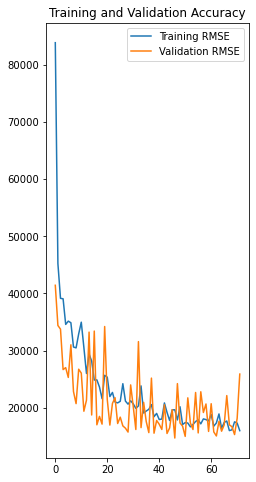

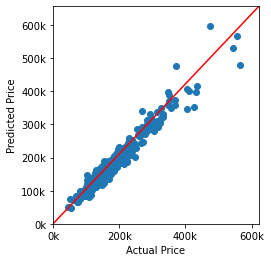

In [18]:
history = best_history

train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')


'''How far are predictions from real values?'''
from matplotlib.ticker import FuncFormatter

def format_tick_labels(x, pos):
    return '{:.0f}k'.format(x/1000)

predictions = model.predict(test_examples)

xlims = [0, max(test_labels)*1.1]
ylims = [0, max(predictions)*1.1]

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(test_labels, predictions)
ax.xaxis.set_major_formatter(FuncFormatter(format_tick_labels))
ax.yaxis.set_major_formatter(FuncFormatter(format_tick_labels))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')

ax.plot(xlims, ylims, 'r-')


### Evaluate on test data

In [27]:
model = create_reg_model()
model.load_weights(os.path.join(ckpt_path, "val_rmse_13775.hdf5"))

loss, acc = model.evaluate(test_examples, test_labels)

print('\nevaluation on test set:\nloss (RMSE) = {:.5f}'.format(loss))

 3/14 [=====>........................] - ETA: 0s - loss: 12921.5547 - rmse: 12921.5547

2022-04-30 22:21:09.694172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 20ms/step - loss: 15474.1807 - rmse: 15414.8867

evaluation on test set:
loss (RMSE) = 15474.18066


In [151]:
%reset -f